In [100]:
import pandas as pd
from pycaret.regression import *

df = pd.read_csv('consumption_temp.csv')

start_time = '2022-05-07 10:00:00'
end_time = '2022-07-07 10:00:00'
location = 'oslo'
use_yr = True

start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

data = df[df['location'].str.lower() == location.lower()]
data['time'] = pd.to_datetime(data['time'])

# Filter the training data based on the start and end time
data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

# Create hour feature
data['hour'] = data['time'].dt.hour
# Create weekday feature
data['weekday'] = data['time'].dt.weekday
# Create month feature
data['month'] = data['time'].dt.month


In [101]:
# Create a new dataframe with temperature data from yr for the same time period to train on
yr_df = pd.read_csv('../yr-data/weather_data_oslo.csv')

# Converting timestamp to same format as the aneo data
yr_df['time'] = pd.to_datetime(yr_df['timestamp'], utc=True)
yr_df['time'] = pd.to_datetime(yr_df['time'].dt.strftime('%Y-%m-%d %H:%M:%S'))

# Remove unnecessary columns
yr_df = yr_df[['time', 'avg_temp']]
yr_df = yr_df.rename(columns={'avg_temp': 'temperature'})

yr_df = yr_df[(yr_df['time'] >= start_time) & (yr_df['time'] <= end_time)]

dataWitoutTemp = data.copy().drop(columns=['temperature'])

aneo_yr = pd.merge(dataWitoutTemp, yr_df, on='time', how='left')

aneo_yr.head()

,time,location,consumption,hour,weekday,month,temperature
0,2022-05-07 10:00:00,oslo,2.439718,10,5,5,13.8
1,2022-05-07 11:00:00,oslo,2.361387,11,5,5,14.6
2,2022-05-07 12:00:00,oslo,2.290941,12,5,5,14.9
3,2022-05-07 13:00:00,oslo,2.390427,13,5,5,15.4
4,2022-05-07 14:00:00,oslo,2.350960,14,5,5,15.1


In [102]:
if use_yr:
    train_data = aneo_yr.copy()
else:
    train_data = data.copy()

# Remove the last 5 days of consumption data
train_data['consumption'] = train_data['consumption'].shift(120)
train_data.dropna(subset=['consumption'], inplace=True)

regression_setup = setup(data=train_data, target='consumption', session_id=123,
                         numeric_features=['temperature', 'hour', 'weekday', 'month'],
                         ignore_features=['time', 'location'], 
                         transform_target=True, data_split_shuffle=False)

,Description,Value
0,Session id,123
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(1345, 7)"
4,Transformed data shape,"(1345, 5)"
5,Transformed train set shape,"(941, 5)"
6,Transformed test set shape,"(404, 5)"
7,Ignore features,2
8,Numeric features,4
9,Rows with missing values,1.8%


In [103]:
# Compare models to select the best one in the next block (comment if already selected)
# best_model = compare_models()


In [104]:
# Create the model with the desired model
model = create_model("rf")

tuned_model = tune_model(model)

final_model = finalize_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0629,0.0070,0.0835,0.3229,0.0361,0.0472
1,0.0569,0.0046,0.0677,0.5124,0.0296,0.0427
2,0.0697,0.0110,0.1048,0.3768,0.0433,0.0512
3,0.0552,0.0051,0.0713,0.4319,0.0344,0.0536
4,0.0867,0.0174,0.1318,0.3092,0.0531,0.0583
5,0.0506,0.0036,0.0600,0.6580,0.0267,0.0392
6,0.0533,0.0038,0.0613,0.7220,0.0265,0.0394
7,0.0546,0.0052,0.0719,0.5147,0.0323,0.0458
8,0.0456,0.0028,0.0525,0.8114,0.0236,0.0377


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0585,0.0051,0.0717,0.5016,0.0309,0.0441
1,0.0504,0.0036,0.0601,0.6159,0.0256,0.0373
2,0.0779,0.0096,0.0981,0.4534,0.0411,0.0574
3,0.0614,0.0050,0.0709,0.4374,0.0344,0.0588
4,0.0860,0.0140,0.1183,0.4433,0.0477,0.0595
5,0.0688,0.0069,0.0833,0.3408,0.0357,0.0509
6,0.0498,0.0040,0.0635,0.7014,0.0264,0.0353
7,0.0554,0.0046,0.0677,0.5706,0.0313,0.0482
8,0.0542,0.0042,0.0650,0.7109,0.0292,0.0446


Fitting 10 folds for each of 10 candidates, totalling 100 fits


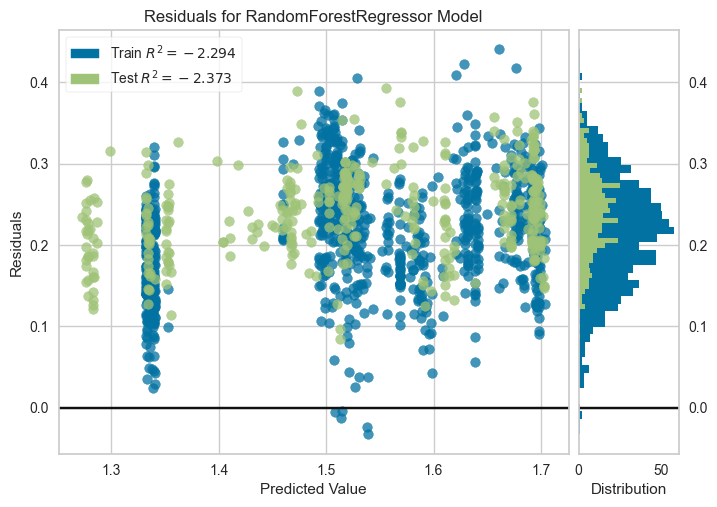

In [105]:
plot_model(final_model)

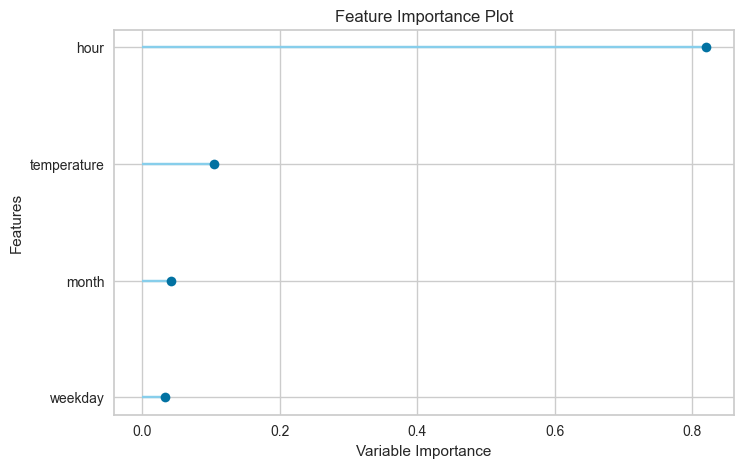

In [106]:
plot_model(final_model, plot='feature')

In [107]:
from datetime import timedelta

number_predict_hours = 24

# The last known time from the original data
last_time = data['time'].iloc[-1]

# Generating future timestamps for the next 24 hours (the hours we want to predict)
future_timestamps = [last_time + timedelta(hours=i) for i in range(1, number_predict_hours + 1)]

future_data = df[df['location'].str.lower() == location.lower()]
future_data['time'] = pd.to_datetime(future_data['time'])

# Limit future data to the next 24 hours after the last known time
future_data = future_data[(future_data['time'] > last_time) & (future_data['time'] <= future_timestamps[-1])]
future_hours = future_data['time'].dt.hour
future_weekdays = future_data['time'].dt.weekday
future_months = future_data['time'].dt.month
future_temperatures = future_data['temperature'].values

print(len(future_data))

# Creating the future_data DataFrame, which will be used for the prediction
future_data = pd.DataFrame({
    'time': future_timestamps,
    'temperature': future_temperatures,
    'location': location,
    'hour': future_hours,
    'weekday': future_weekdays,
    'month': future_months
})

# Predict the consumption for the next 24 hours using the trained model
future_data['time'] = pd.to_datetime(future_data['time'])
predictions = predict_model(final_model, data=future_data)

24


In [108]:
predictions

,time,temperature,location,hour,weekday,month,prediction_label
10871,2022-07-07 11:00:00,21.000000,oslo,11,3,7,2.386760
10876,2022-07-07 12:00:00,21.100000,oslo,12,3,7,2.386760
10881,2022-07-07 13:00:00,22.000000,oslo,13,3,7,2.498907
10886,2022-07-07 14:00:00,22.600000,oslo,14,3,7,2.657184
10891,2022-07-07 15:00:00,22.600000,oslo,15,3,7,2.684785
10896,2022-07-07 16:00:00,22.400000,oslo,16,3,7,2.684785
10901,2022-07-07 17:00:00,21.799999,oslo,17,3,7,2.684785
10906,2022-07-07 18:00:00,21.299999,oslo,18,3,7,2.659601
10911,2022-07-07 19:00:00,19.600000,oslo,19,3,7,2.645789
10916,2022-07-07 20:00:00,18.400000,oslo,20,3,7,2.645789


In [109]:
import pandas as pd
from pycaret.regression import *

solution = df[df['location'].str.lower() == location.lower()]
solution['time'] = pd.to_datetime(solution['time'])

# Filter the training data based on the start and end time
solution = solution[(solution['time'] > last_time) & (solution['time'] <= future_timestamps[-1])]

# Create hour feature
solution['hour'] = solution['time'].dt.hour
# Create weekday feature
solution['weekday'] = solution['time'].dt.weekday
# Merge the DataFrames
merged_data = predictions.copy()
merged_data['consumption'] = solution['consumption']
merged_data = merged_data.rename(columns={'prediction_label': 'predicted_consumption'})
merged_data.head()

,time,temperature,location,hour,weekday,month,predicted_consumption,consumption
10871,2022-07-07 11:00:00,21.0,oslo,11,3,7,2.386760,2.210491
10876,2022-07-07 12:00:00,21.1,oslo,12,3,7,2.386760,2.232275
10881,2022-07-07 13:00:00,22.0,oslo,13,3,7,2.498907,2.270914
10886,2022-07-07 14:00:00,22.6,oslo,14,3,7,2.657184,2.480187
10891,2022-07-07 15:00:00,22.6,oslo,15,3,7,2.684785,2.612685


<AxesSubplot: title={'center': 'Predictions for the next 24 hours'}, xlabel='time', ylabel='MV'>

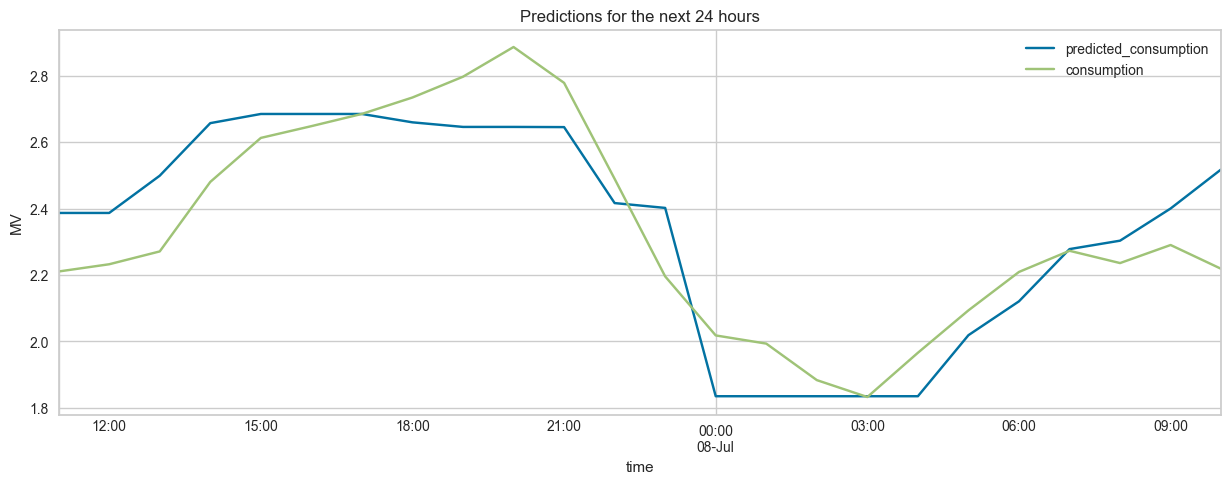

In [110]:
merged_data.plot(x='time', y=['predicted_consumption', 'consumption'], ylabel="MV", figsize=(15, 5), title=f'Predictions for the next {number_predict_hours} hours')